# Prepare ODs (TAZs)

In [6]:
import geopandas as gpd
import pandas as pd
from pathlib import Path
import json
import pickle

import src.bikewaysim_functions as bikewaysim_functions

import sys
sys.path.insert(0,str(Path.cwd().parent))
import file_structure_setup
config = file_structure_setup.filepaths()

In [7]:
taz_fp = Path("D:\RAW\Atlanta_Regional_Comission\Model_Traffic_Analysis_Zones_2020.geojson")
trip_fp = [
    r"D:\RAW\Atlanta_Regional_Comission\rtp_amd6_2030_tripData/tripData.csv",
    r"D:\RAW\Atlanta_Regional_Comission\rtp_amd6_2030_tripData/tripData_1.csv",
    r"D:\RAW\Atlanta_Regional_Comission\rtp_amd6_2030_tripData/tripData_2.csv"
]

outputs = []

# Initial Count

In [8]:
# to get how many tazs
all_tazs = gpd.read_file(taz_fp,ignore_geometry=True).shape[0]


### Import ARC Trip Data from TIP Amendment Six 2030 Model Run
### https://abmfiles.atlantaregional.com/downloads/zPrevious%20Model%20-%20Loaded%20Highway%20Networks%20-%20GIS%20-%20RTP%20Amd%206%20-%202030.zip
tripData0 = pd.read_csv(trip_fp[0],usecols=['orig_taz','dest_taz','distance','hh_id','person_id'])
tripData1 = pd.read_csv(trip_fp[1],usecols=['orig_taz','dest_taz','distance','hh_id','person_id'])
tripData2 = pd.read_csv(trip_fp[2],usecols=['orig_taz','dest_taz','distance','hh_id','person_id'])
tripData = pd.concat([tripData0,tripData1,tripData2])
del tripData0, tripData1, tripData2

outputs.append([
    all_tazs,
    tripData.groupby(['orig_taz','dest_taz']).ngroups,
    tripData.shape[0],
    tripData['hh_id'].nunique(),
    tripData['person_id'].nunique()
])

# Within Study Area

In [9]:
studyarea = gpd.read_file(config['studyarea_fp'])
tazs = gpd.read_file(taz_fp,mask=studyarea)[['MTAZ10','geometry']]
tazs.rename(columns={'MTAZ10':'tazid'},inplace=True)

tripData = tripData[tripData['orig_taz'].isin(tazs['tazid']) & tripData['dest_taz'].isin(tazs['tazid'])]

outputs.append([
    tazs.shape[0],
    tripData.groupby(['orig_taz','dest_taz']).ngroups,
    tripData.shape[0],
    tripData['hh_id'].nunique(),
    tripData['person_id'].nunique()
])

# Remove if matching distance exceeded 500 feet
Euclidean matching distance is less than or equal to 500 feet (~2.5 minutes walking at 2 mph)

In [10]:
## Snap TAZs to network
nodes = gpd.read_file(config['network_fp']/"final_network.gpkg",layer="nodes")
with (config['calibration_fp']/"calibration_network.pkl").open('rb') as fh:
    links,turns = pickle.load(fh)
del turns
nodes0 = links['A'].append(links['B'])
nodes = nodes[nodes['N'].isin(nodes0)]
tazs = bikewaysim_functions.snap_ods_to_network(tazs,nodes)

#filter
tazs = tazs[tazs['dist']<=500]
tripData = tripData[tripData['orig_taz'].isin(tazs['tazid']) & tripData['dest_taz'].isin(tazs['tazid'])]

outputs.append([
    tazs.shape[0],
    tripData.groupby(['orig_taz','dest_taz']).ngroups,
    tripData.shape[0],
    tripData['hh_id'].nunique(),
    tripData['person_id'].nunique()
])

# Remove Trips Above 3 Miles


In [12]:
tripData = tripData[tripData['distance'] <= 3]

#filter tazs
tazs = tazs[tazs['tazid'].isin(tripData['orig_taz']) | tazs['tazid'].isin(tripData['dest_taz'])]

outputs.append([
    tazs.shape[0],
    tripData.groupby(['orig_taz','dest_taz']).ngroups,
    tripData.shape[0],
    tripData['hh_id'].nunique(),
    tripData['person_id'].nunique()
])

# Remove Intrazonal Trips


In [13]:
tripData = tripData[tripData['orig_taz'] != tripData['dest_taz']]

#filter tazs
tazs = tazs[tazs['tazid'].isin(tripData['orig_taz']) | tazs['tazid'].isin(tripData['dest_taz'])]

outputs.append([
    tazs.shape[0],
    tripData.groupby(['orig_taz','dest_taz']).ngroups,
    tripData.shape[0],
    tripData['hh_id'].nunique(),
    tripData['person_id'].nunique()
])

In [14]:
#condense tripData
tripData = tripData.groupby(['orig_taz','dest_taz']).size().reset_index()
tripData.columns = ['orig_taz','dest_taz','trips']

# Final Count

In [17]:
pd.DataFrame(outputs,columns=['Number of TAZs','Number of OD Pairs','Number of Trips','Number of Households','Number of Persons']).iloc[:,-2:]

,Number of Households,Number of Persons
0,2481224,5427425
1,784992,1187904
2,672054,988552
3,517835,708466
4,483576,653522


# add snapped nodes to trip data


In [ ]:
snapped_ods = dict(zip(tazs['tazid'],tazs['N']))
tripData['orig_N'] = tripData['orig_taz'].map(snapped_ods)
tripData['dest_N'] = tripData['dest_taz'].map(snapped_ods)

Create trips per origin/destination visual

In [ ]:
# trip_origins_per_taz = tripData.groupby('orig_taz')['trips'].sum().reset_index()
# trip_origins_per_taz.columns = ['tazid','trip_origins']
# trip_destinations_per_taz = tripData.groupby('dest_taz')['trips'].sum().reset_index()
# trip_destinations_per_taz.columns = ['tazid','trip_destinations']

# trips_per_taz = tazs.copy()
# trips_per_taz = trips_per_taz.merge(trip_origins_per_taz,on='tazid',how='left')
# trips_per_taz = trips_per_taz.merge(trip_destinations_per_taz,on='tazid',how='left')
# trips_per_taz['both'] = trips_per_taz['trip_origins'] + trips_per_taz['trip_destinations']
# trips_per_taz.fillna(0,inplace=True)
# ax = trips_per_taz.plot('both',cmap='YlGnBu',edgecolor='grey')
# plt.axis('off')
# plt.show()

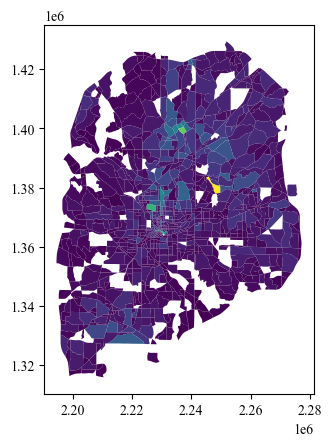

In [ ]:
trip_origins_per_taz = tripData.groupby('orig_taz')['trips'].sum().reset_index()
trip_origins_per_taz.columns = ['tazid','trip_origins']
trip_origins_per_taz = tazs.merge(trip_origins_per_taz,on='tazid')
trip_origins_per_taz.plot('trip_origins')
trip_origins_per_taz.to_file(config['bikewaysim_fp']/'ods.gpkg',layer='trip_origins')

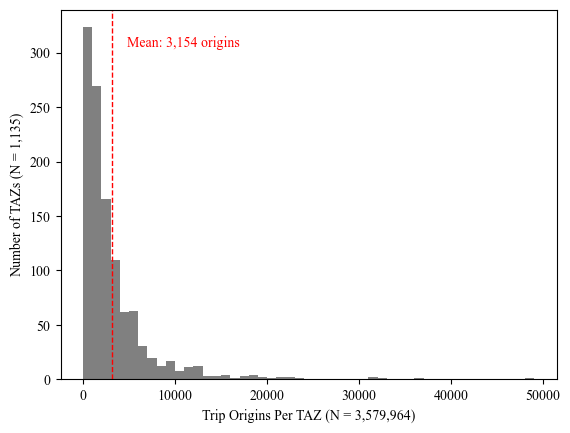

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Times New Roman'
plt.hist(trip_origins_per_taz['trip_origins'], bins=range(0, 50000, 1000), color='grey')
plt.grid(False)
plt.xlabel(f"Trip Origins Per TAZ (N = {trip_origins_per_taz['trip_origins'].sum():,})")
plt.ylabel(f"Number of TAZs (N = {trip_origins_per_taz.shape[0]:,})")
# Add vertical red line at the mean value
plt.axvline(trip_origins_per_taz['trip_origins'].mean(), color='red', linestyle='dashed', linewidth=1)
# Add label for the mean value
plt.text(trip_origins_per_taz['trip_origins'].mean() * 1.5, plt.gca().get_ylim()[1] * 0.9, f"Mean: {trip_origins_per_taz['trip_origins'].mean():,.0f} origins", color='red', ha='left')
plt.show()

In [ ]:
trip_origins_per_taz['trip_origins'].mean()

3154.153303964758

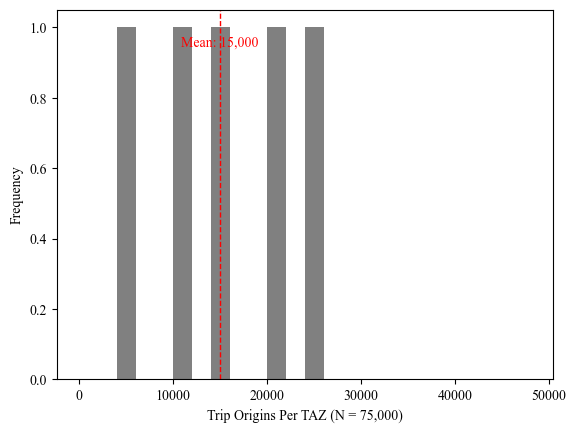

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Example DataFrame
trip_origins_per_taz = pd.DataFrame({'trip_origins': [10000, 20000, 15000, 5000, 25000]})

# Set the font to Times New Roman
plt.rcParams['font.family'] = 'Times New Roman'

# Create histogram
plt.hist(trip_origins_per_taz['trip_origins'], bins=range(0, 50000, 2000), color='grey')

# Remove grid lines
plt.grid(False)

# Calculate the sum of trip origins with comma formatting
total_trip_origins = f"{trip_origins_per_taz['trip_origins'].sum():,}"

# Add axis labels with formatted number
plt.xlabel(f"Trip Origins Per TAZ (N = {total_trip_origins})")
plt.ylabel('Frequency')

# Calculate the mean value
mean_value = trip_origins_per_taz['trip_origins'].mean()

# Add vertical red line at the mean value
plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=1)

# Add label for the mean value
plt.text(mean_value, plt.gca().get_ylim()[1] * 0.9, f'Mean: {mean_value:,.0f}', color='red', ha='center')

# Show plot
plt.show()


In [ ]:
# trip_destinations_per_taz = tripData.groupby('dest_taz')['trips'].sum().reset_index()
# trip_destinations_per_taz.columns = ['tazid','trip_destinations']
# trip_destinations_per_taz = tazs.merge(trip_destinations_per_taz,on='tazid')
# trip_destinations_per_taz.plot('trip_destinations')

## Get the TAZs within the study area that were filtered out or had zero trips

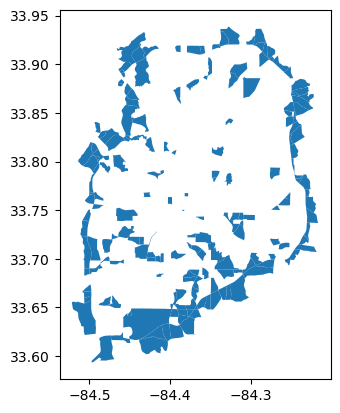

In [ ]:
studyarea = gpd.read_file(config['studyarea_fp'])
tazs0 = gpd.read_file(taz_fp,mask=studyarea)[['MTAZ10','geometry']]
tazs0.rename(columns={'MTAZ10':'tazid'},inplace=True)

tazs0 = tazs0[tazs0['tazid'].isin(tazs['tazid'])==False]
tazs0.plot()

tazs0.to_file(config['bikewaysim_fp']/'ods.gpkg',layer='filtered_out_or_zero')

In [ ]:
# # trip origins per TAZ

# #export the taz areas
# tazs.to_crs(config['projected_crs_epsg']).to_file(config['bikewaysim_fp']/'map_layers.gpkg',layer='taz_polygons')
# #export the taz centroids
# taz_centroids = tazs.copy().to_crs(config['projected_crs_epsg'])
# taz_centroids.geometry = taz_centroids.geometry.centroid
# taz_centroids.to_crs(config['projected_crs_epsg']).to_file(config['bikewaysim_fp']/'map_layers.gpkg',layer='taz_centroids')

In [ ]:
#export
tripData.to_csv(config['bikewaysim_fp']/'od_matrix.csv',index=False)

In [ ]:
tripData0 = pd.read_csv(trip_fp[0])

In [ ]:
tripData0[['hh_id','person_id']].nunique()

hh_id        2481076
person_id    5423171
dtype: int64

In [ ]:
tripData0['trip_mode'].value_counts()

1     11561282
3      5604942
5      3920177
7      1040802
15      925286
2       215819
9       207067
8       104353
10       42324
12       42131
13       31912
14       21014
4        16028
6        14541
11        5231
Name: trip_mode, dtype: int64

In [ ]:
tripData0.groupby('hh_id')['person_id'].nunique().value_counts()

1     959369
2     712175
3     410669
4     262282
5      88812
6      31185
7       9952
8       4111
9       1555
10       518
11       175
12       111
13       106
14        55
15         1
Name: person_id, dtype: int64

In [ ]:
tripData0[tripData0['person_num']>4].sort_values('hh_id').head(20)

,hh_id,person_id,person_num,tour_id,stop_id,inbound,tour_category,tour_purpose,orig_purpose,dest_purpose,...,travel_time,distance,cost,first_wait_time,xfer_wait_time,walk_aux_time,auto_aux_time,boardings,ivt_local_bus,ivt_premium_modes
2525,3,13,6,0,-1,1,MANDATORY,school_predrive,school,Home,...,15.340000,1.78,0.0,6.0,0.0,4.0,0.0,0.0,0.0,0.0
2524,3,13,6,0,-1,0,MANDATORY,school_predrive,Home,school,...,15.340000,1.78,0.0,6.0,0.0,4.0,0.0,0.0,0.0,0.0
2523,3,12,5,0,-1,1,INDIVIDUAL_NON_MANDATORY,escort_kids,escort,Home,...,11.240000,2.82,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2522,3,12,5,0,1,0,INDIVIDUAL_NON_MANDATORY,escort_kids,shopping,escort,...,27.610001,8.04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2521,3,12,5,0,0,0,INDIVIDUAL_NON_MANDATORY,escort_kids,Home,shopping,...,22.559999,7.22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2520,3,12,5,0,-1,1,MANDATORY,school_predrive,school,Home,...,20.020000,3.34,0.0,6.0,0.0,4.0,0.0,0.0,0.0,0.0
2519,3,12,5,0,-1,0,MANDATORY,school_predrive,Home,school,...,20.020000,3.34,0.0,6.0,0.0,4.0,0.0,0.0,0.0,0.0
1391,5,20,5,0,1,0,INDIVIDUAL_NON_MANDATORY,shopping,shopping,shopping,...,12.950000,0.59,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1392,5,20,5,0,0,1,INDIVIDUAL_NON_MANDATORY,shopping,shopping,escort,...,12.950000,0.59,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1387,5,20,5,0,0,0,JOINT_NON_MANDATORY,othdiscr,Home,eatout,...,16.040001,4.60,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
tripData0.groupby('person_id')['tour_id'].nunique().value_counts()

1    3786186
2    1364741
3     228548
4      38369
5       5159
6        159
7          9
Name: tour_id, dtype: int64

In [ ]:
tripData0.columns

Index(['hh_id', 'person_id', 'person_num', 'tour_id', 'stop_id', 'inbound',
       'tour_category', 'tour_purpose', 'orig_purpose', 'dest_purpose',
       'orig_taz', 'dest_taz', 'orig_walk_segment', 'dest_walk_segment',
       'parking_taz', 'depart_period', 'trip_mode', 'tour_mode',
       'num_participants', 'tour_participants', 'tour_start_period',
       'tour_id_uniq', 'trip_id', 'orig_purpose_start_period', 'home_taz',
       'hh_income', 'hh_autos', 'hh_fp_choice', 'hh_inc_bin', 'hh_size',
       'hh_wkrs', 'hh_auto_suff', 'age', 'gender', 'person_type',
       'activity_pattern', 'tour_mode_name', 'trip_mode_name', 'travel_time',
       'distance', 'cost', 'first_wait_time', 'xfer_wait_time',
       'walk_aux_time', 'auto_aux_time', 'boardings', 'ivt_local_bus',
       'ivt_premium_modes'],
      dtype='object')

In [ ]:
# tazs.to_file(config['bikewaysim_fp']/'ods.gpkg',layer='tazs')
